# Covid-19 Notebook
This notebook show how to explore some of the Covid-19 infection data. It relies on a module called `corona` and makes use of data as compiled by the Johns Hopkins University.

In [1]:
from corona import Corona

In order to get help on the Corona class, simply use `help(Corona)`, as illustrated below.

In [2]:
help(Corona)

Help on class Corona in module corona:

class Corona(builtins.object)
 |  Retrieve, view and analyze data on the spread of Covid-19
 |  
 |  It uses data compiled by Johns Hopkins University and published on their Github repo
 |  
 |  Methods defined here:
 |  
 |  __init__(self)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  countries(self, regex=None)
 |      Returns a list of countries available. Useful to search for countries if you don't
 |         know the exact name
 |      Args:
 |          regex (string): If provided, uses it to match case insensitively anywhere in
 |              country name
 |  
 |  country_data(self, country=None, offset_before_first_case=None)
 |      Returns the data for a single country or the world
 |      Args:
 |          country (string): The country for which to fit, world if None (see countries())
 |      Keyword Arguments:
 |          offset_before_first_case (int): The number of days before the first case to star

Start of by creating a `Corona` class instance and reading the data from the JHU Github page.

In [3]:
corona = Corona()
corona.read_jhu()

It is possible to do various plots of the data by using the do_plot() method. See the documentation above for a full description.

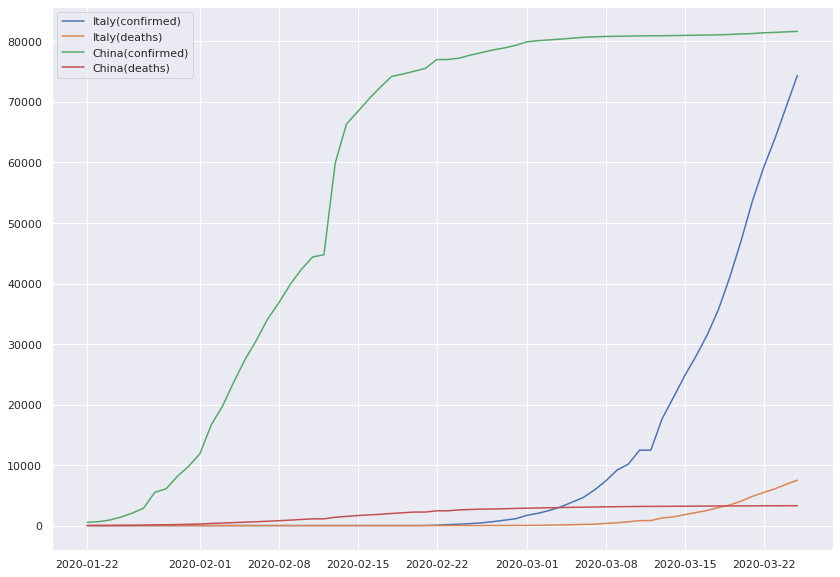

In [4]:
corona.do_plot(['Italy', 'China'], ['confirmed', 'deaths'])

In order to see which countries are available, use the `countries()` method as illustrated below

In [5]:
corona.countries('afri')

['Central African Republic', 'South Africa']

The `do_plot()` method can offset data in order to more easily compare growth rates.

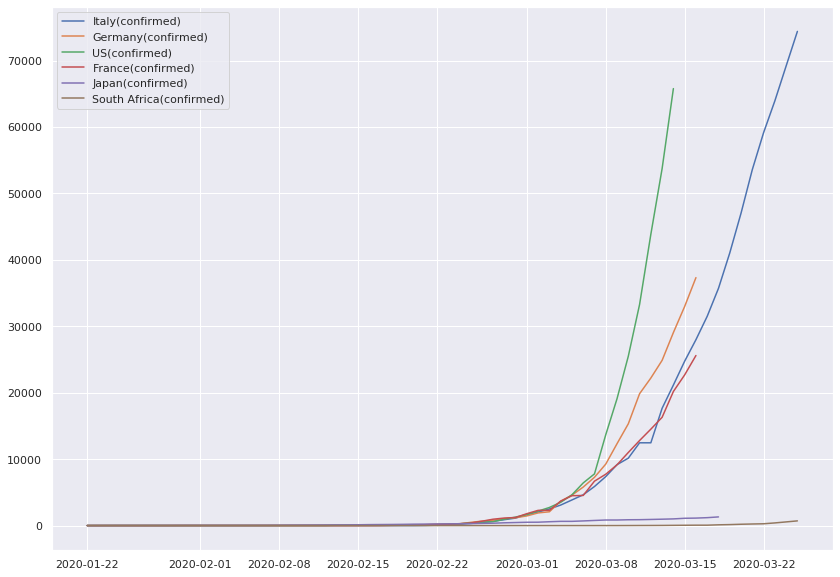

In [6]:
corona.do_plot(['Italy', 'Germany', 'US', 'France', 'Japan', 'South Africa'], ['confirmed'], [0,9,11, 9, 7, 0])

It is also possible to use a log scale for y-axis (Thanks Eben)

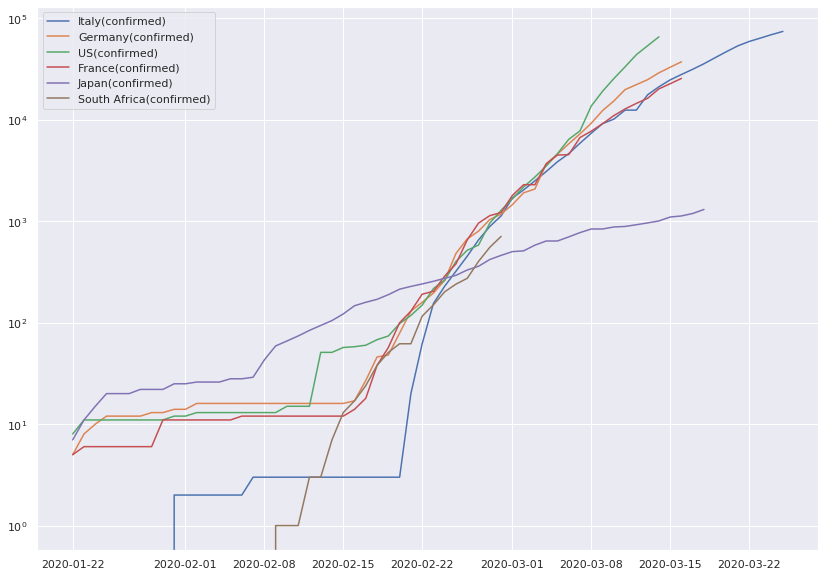

In [7]:
corona.do_plot(['Italy', 'Germany', 'US', 'France', 'Japan', 'South Africa'], ['confirmed'], [0, 9, 11, 9, 7, 25], 'log')

The `curve_fit()` method fits an exponential and logistic curve to the data. Disease spreading models are generally much more complicated than this might suggest. The simplest model (SIR) consists of 3 first order differential equations. These curve fit simply show a best can worst case scenario. Even in the worst case scenario, this will be limited by population size, and will eventually become logistic when more than half the population is infected (assuming everybody is ineffectable).
The logistic midpoint is when the spread is half-way through, and the total infected will be twice the number on this day. This is heavily influence by the last number of data points making it a very weak predictor.

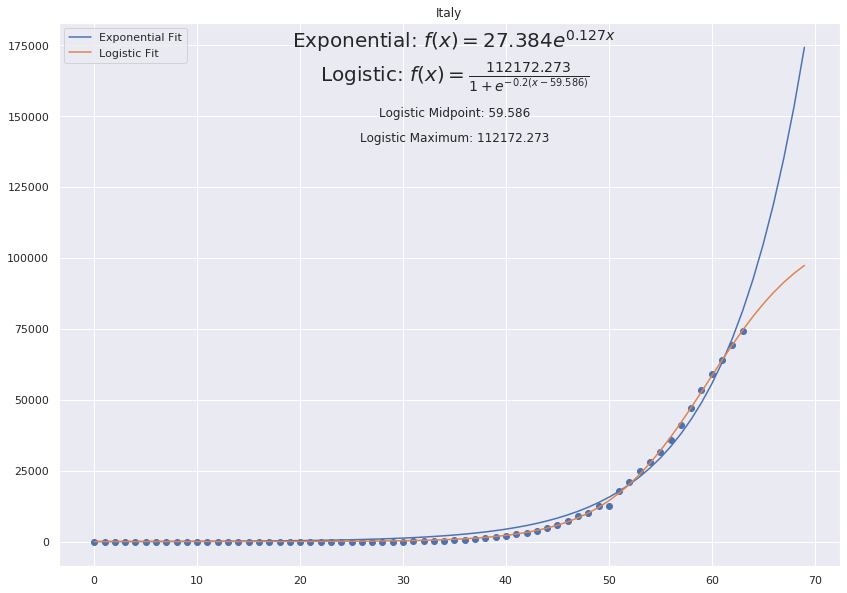

In [8]:
corona.curve_fit('Italy', 70)

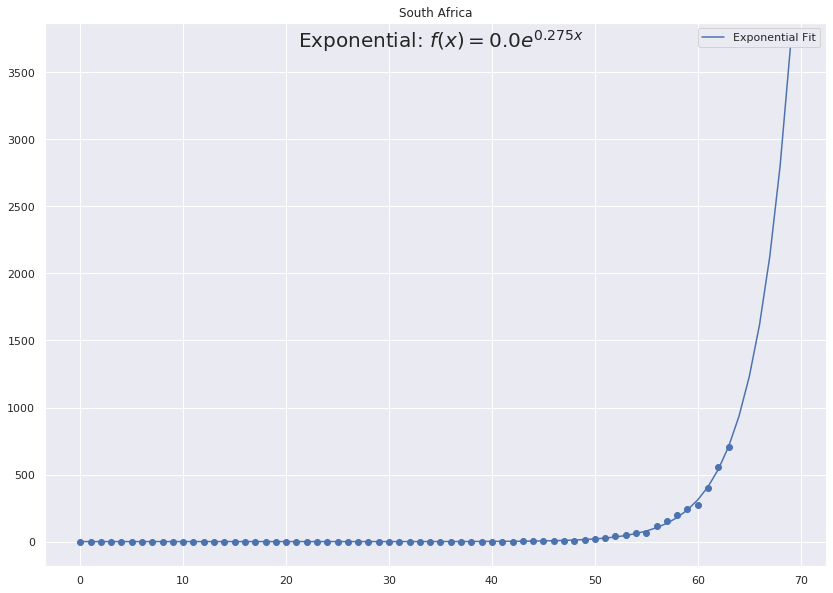

In [9]:
corona.curve_fit('South Africa', 70)

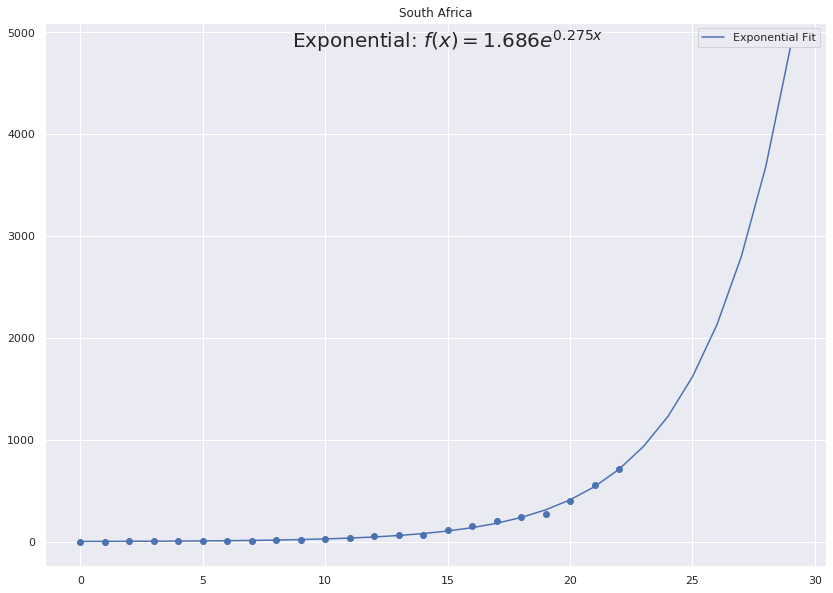

In [11]:
corona.curve_fit('South Africa', 30, 2)

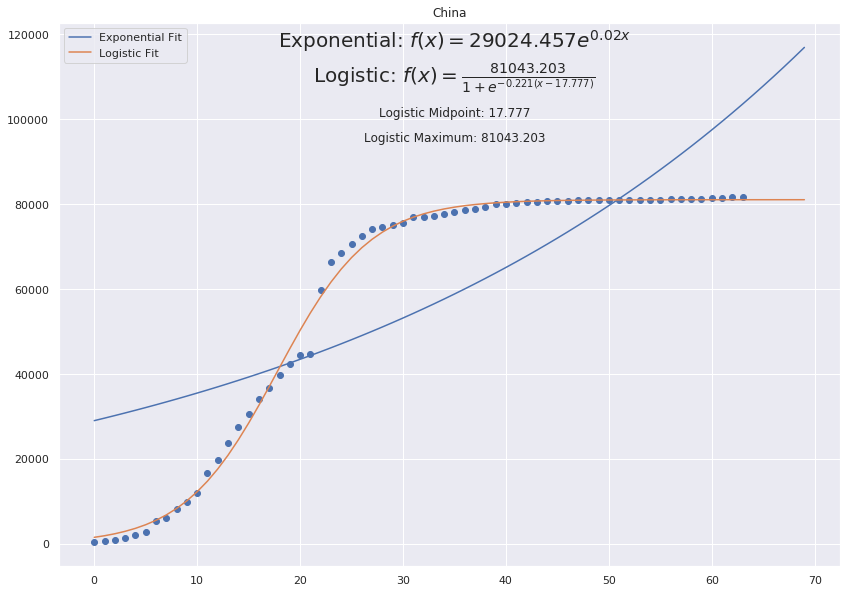

In [12]:
corona.curve_fit('China', 70)

The above exponential curve does not fit well. It possible to limit the number of days used for fitting the exponential curve. It seems that the exponential phase ends after about 23 days.

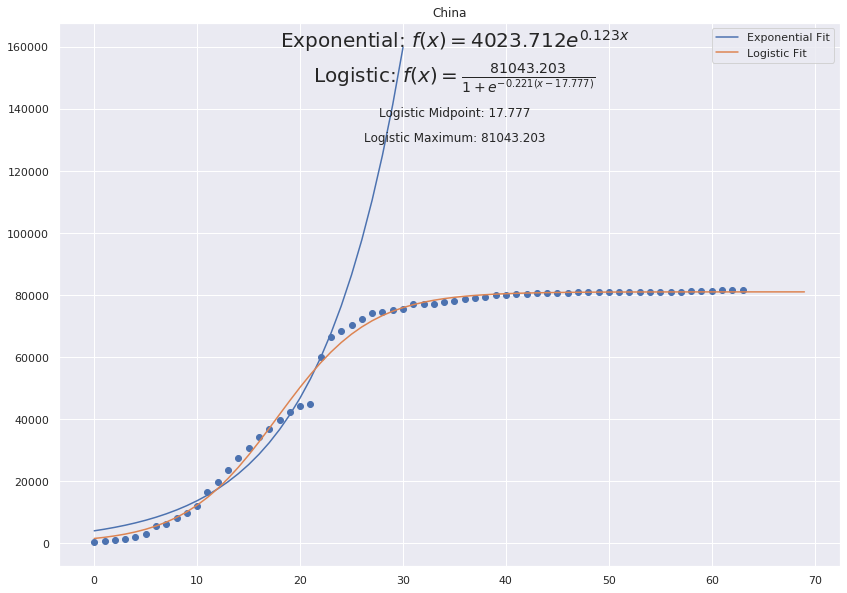

In [13]:
corona.curve_fit('China', 70, expo_day_limit=23)

It is also possible to get summary stats per country or for the world. This functionality can be improved.

In [14]:
corona.country_stats('South Africa')

{'Number of Infections': 709,
 'Number of Deaths': 0,
 'Number of Recoveries': 0.0,
 'Mortality Rate': 0.0,
 'First Infection': 21}